In [1]:
from draw_lines import prepare_features
import os
import cv2 as cv
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
import matplotlib.pyplot as plt

training/057.tif


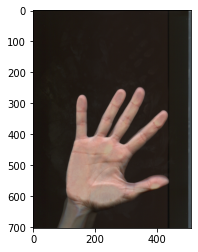

In [2]:
listing = list(os.scandir("training"))
def get_rand_im():
    a = random.sample(listing, 1)[0].path
    print(a)
    return cv.imread(a)

img = get_rand_im()
H, W, _ = img.shape
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

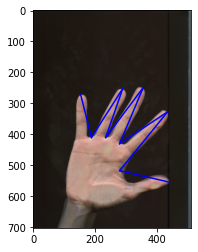

In [3]:
c_h, c_w, local_maxs, local_mins, lines = prepare_features(img)
for l in lines:
    plt.plot([l[1][1] + c_w, l[0][1] + c_w], [l[1][0] + c_h, l[0][0] + c_h], c="blue")
    plt.plot([l[1][1] + c_w, l[2][1] + c_w], [l[1][0] + c_h, l[2][0] + c_h], c="blue")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

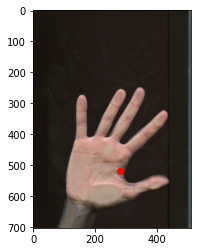

In [4]:
def nearest_dist(lines, i):
    return min([np.linalg.norm(lines[i][1] - lines[j][1]) for j in range(len(lines)) if
                i != j])
def nearest_ind(lines, v):
    return np.array([np.linalg.norm(v - lines[j][1]) for j in range(len(lines))]).argmin()

i = np.array([nearest_dist(lines, i) for i in range(len(lines))]).argmax()
plt.scatter([lines[i][1][1] + c_w], [lines[i][1][0] + c_h], c="r")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

In [5]:
def order_lines(lines):
    i = np.array([nearest_dist(lines, i) for i in range(len(lines))]).argmax()
    lines = lines[::]
    ordered_lines = [lines[i]]
    cur_l = lines.pop(i)
    while len(lines):
        i = nearest_ind(lines, cur_l[1])
        ordered_lines.append(lines[i])
        cur_l = lines.pop(i)
    return ordered_lines

ordered_lines = order_lines(lines)
feature = np.array([[np.linalg.norm(l[1] - l[0]), np.linalg.norm(l[1] - l[2])] for l in
                    ordered_lines]).flatten()
print(feature)

[245.2039967  164.22241016 196.30843079 186.1021225  167.29913329
 201.4000993  143.33875959 187.52333188]


In [6]:
def get_feature(img):
    c_h, c_w, local_maxs, local_mins, lines = prepare_features(img)
    ordered_lines = order_lines(lines)
    feature = np.array([[np.linalg.norm(l[1] - l[0]), np.linalg.norm(l[1] - l[2])] for l in
                        ordered_lines]).flatten()
    return feature

In [7]:
# need to del 034.tif
def get_features():
    features, labels = [], []
    for p in os.scandir("training"):
        labels.append(p.name)
    if os.path.exists("features.npy"):
        X = np.load("features.npy")
    else:
        for p in os.scandir("training"):
            try:
                img = cv.imread(p.path)
                features.append(get_feature(img))
            except Exception as e:
                print(e)
        X = np.vstack(features)
        np.save("features", X)
    return X, labels

X, labels = get_features()

In [8]:
dists = ((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2).sum(axis=2) ** 0.5
three_nearest = dists.argsort(axis=1)[:, 1:4]
d = {"object": [], "nearests": []}
for i in range(len(labels)):
    d["object"].append(labels[i])
    d["nearests"].append(';'.join([labels[j] for j in three_nearest[i]]))
pd.DataFrame.from_dict(d).to_csv('./nearests.csv')

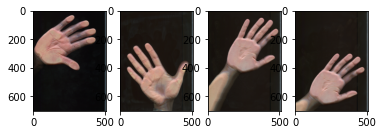

In [9]:
ind = random.choice(list(range(len(labels))))
img = cv.imread(os.path.join("training", labels[ind]))
nearests = []
for i in three_nearest[ind]:
    nearests.append(cv.imread(os.path.join("training", labels[i])))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax2.imshow(cv.cvtColor(nearests[0], cv.COLOR_BGR2RGB))
ax3.imshow(cv.cvtColor(nearests[1], cv.COLOR_BGR2RGB))
ax4.imshow(cv.cvtColor(nearests[2], cv.COLOR_BGR2RGB));

In [10]:
for n_clusters in range(5, 50):
    kmeans_setting = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans_setting.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(n_clusters, silhouette_avg)


5 0.3744278427196555
6 0.29409888699836395
7 0.2911695519148004
8 0.31324845138012036
9 0.28303268067797865
10 0.303937573855496
11 0.2696341463137424
12 0.28515858307190955
13 0.2683689145335469
14 0.24864415528190698
15 0.2804431746229882
16 0.27920491339488684
17 0.26696217751693035
18 0.26318573907495924
19 0.2668588974142174
20 0.2708115733268378
21 0.28761890694563136
22 0.25901399293651106
23 0.25690887445755806
24 0.26710048227282096
25 0.2772700837586588
26 0.2681361635787896
27 0.26193611199189387
28 0.2650101580191031
29 0.23015017582119765
30 0.26740651788387604
31 0.2522971282260684
32 0.2592992572902133
33 0.26657368495048717
34 0.2589187925645552
35 0.25912008008697507
36 0.27223939705231226
37 0.25794660400745656
38 0.2540038153959899
39 0.24965373633072818
40 0.2507688098141024
41 0.2664556381958562
42 0.25577657094740314
43 0.24542931901947077
44 0.24519197221530342
45 0.2502851070077144
46 0.25468304805792
47 0.241748754435813
48 0.24749313364138456
49 0.243113802285

In [11]:
n_clusters = 18
kmeans_setting = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = kmeans_setting.fit_predict(X)
cur_cl = random.choice(list(range(n_clusters)))
cluster_names = np.array(labels)[cluster_labels==cur_cl].tolist()

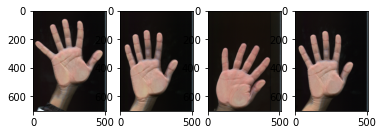

In [12]:
imgs = []
for name in cluster_names:
    imgs.append(cv.imread(os.path.join("training", name)))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(cv.cvtColor(imgs[0], cv.COLOR_BGR2RGB))
ax2.imshow(cv.cvtColor(imgs[1], cv.COLOR_BGR2RGB))
ax3.imshow(cv.cvtColor(imgs[2], cv.COLOR_BGR2RGB))
ax4.imshow(cv.cvtColor(imgs[3], cv.COLOR_BGR2RGB));